$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

Sklearn not installed, some features might not be usable


## Generative adversarial training of movement primitives 

The goal is to develop new model-based movement primitives that can be trained from demonstrations $\bm{\tau}$ of trajectories that fulfill the following criterion :
- we should be able not only to retrieve the mean trajectory, but to sample from a distribution of trajectory that match the distribution of demonstrations
- the trajectories should by dynamically consistent or directly applicable on the robot with a policy
- it should be robust to perturbations/model uncertainties/various initial states
- it should be able to adapt to position of objects 
- it should be able to retrieve trajectories that are define in joint angles, different task space or other distribution. It should be learn jointly to take into account the dependencies between the different objectives.

In the generative adversarial framework, we train a generator $G(\bm{z}; \bm{\theta})$ that takes as input noise variable $p_z(\bm{z})$ and generate samples that looks like the distribution of data $\bm{x}$ we have. To do this, we train another network, a discriminator that outputs the probability that $\bm{x}$ came from the data rather than from the generator. In each step of the training, we first optimize the discriminator with a few step of SGD and the perform one step of the generator. 

In our task to generate dynamically consistent trajectories, the generator consist of multiple elements ($\bm{\xi}$ is the state, $\bm{u}$ the control command).
- a stochastic policy (time-dependent or not): $\bm{u}_{t} \sim \pi(\bm{\xi}_t, t)$ 
- a stochastic discrete time system : $\bm{\xi}_{t+1} \sim f(\bm{\xi}_t, \bm{u}_t)$
By sampling sequentially from these, we can generate whole trajectories $\bm{\tau} = \{\bm{\xi}_0, \bm{u}_0, ..., \bm{\xi}_T, \bm{u}_T\}$. Our goal is to make those samples match the demonstrations we have. 

Instead of training a discriminator as a MLP, we propose to use efficient techniques that can be trained in closed form or with very efficient procedures like EM. We found that it increases the stability, the speed and provide a regularization to the training.  

We create two approximate distributions $q_{samples}$ and $q_{data}$ and compute the probability of the generated samples trajectories $\tau$ to be in the distribution of data rather than samples as 
$$\frac{q_{data}(\tau)}{q_{data}(\tau) + q_{samples}(\tau)}$$

The generator has to maximize this probability. Before each step of gradient descent of the generator, we train the discriminator by updating $p_{samples}$ with maximum likelihood with samples from the generator. As it is costly to generate to much samples from the generator, we can learn $p_{samples}$ incrementally by keeping data from previous solutions or doing stochastic update as in online learning. There are some version of EM that allows for stochastic upgrades. For example, the mean is a weighted average of the previous mean and the mean of the new data.

### Remarks

Inverse optimal control (IOC) also learn a distribution of dynamically consistent trajectories as 
$$p(\bm{\tau}) \propto \exp(-c(\bm{\tau})) $$
where $c$ is a cost function. For computing a estimation of the gradient of $p$ complex approximation techniques are required (basically, the forward problem of generating the widest distribution of trajectories minimizing this cost has to be solved at each iteration). The solution is a cost function, that might be a more compact, elegant and transferable representation of task than a policy but more complicated to get. Our method models the policy directly. We show that we can also abstract the dependence to the dynamic by training a policy that works with different models and stochasticity.

If you learn $p_{samples}(\tau)$ for the discriminator, why not using it directly : well this is a good question !
The principle and easy answer is that it complicated to then generate dynamically consistent samples that match $p_{samples}(\tau)$. Also, this distribution can be very rough, drop dependencies, etc... A good example is a HMM, it is easy to train by we loose the dynamic dependencies and then we need LQR to regenerate trajectories. But the regenerated trajectories does not look very much like our data at the beginning. There are also other reasons. For example, if we want to learn distribution both in joint space and operational space, or different coordinate system. One approach is to learn independent distribution and to fuse them only when controlling the system. It makes the false assumption that everything is independent. At the end, the fusion of the controller does not allow to retrieve the desired distribution of trajectories.

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

###  Get letter data

In [3]:
dt = 0.01
demos_xi = rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True)

In [4]:
def get_batch(batch_size=10, fast=False):
    idx = np.random.randint(0, demos_xi.shape[0]-1, batch_size)
    if fast:
        t = np.random.randint(0, demos_horizon-1-horizon)
        return demos_xi[idx, t], t
    else:
        return demos_xi[idx, 0], 0

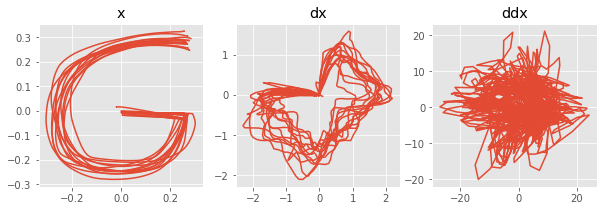

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
for i, title in enumerate(['x', 'dx', 'ddx']): ax[i].set_title(title)

for d in demos_xi:
    ax[0].plot(d[:, 0], d[:, 1])
    ax[1].plot(d[:, 2], d[:, 3])
    ax[2].plot(d[:, 4], d[:, 5])
    [_ax.set_prop_cycle(None) for _ax in ax]

###  Define parameters

In [6]:
# use faster training by splitting whole trajectories and using smaller horizon 
fast = False

In [7]:
xi_dim = 4  # size of state
u_dim = 2  # size of control command
batch_size = 10  # batch_size (number of trajectories to evaluate in parrallel to compute gradient)
horizon = 200 if not fast else 50  # horizon of the rollouts to evaluate for computing gradients
demos_horizon = 200 # whole horizon of the demonstrations

## Define generator of trajectories 

In [8]:
xi0 = tf1.placeholder(tf.float32, (batch_size, xi_dim))  # placeholder for initial state

In [9]:
# we say that the robot is control by inverse dynamics, so we only care about generating
# trajectories with double integretor system
A, B = rl.control.utils.get_canonical(nb_deriv=2, nb_dim=u_dim, dt=dt)  # get linear system (double integrator)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Define discrete time deterministic system as  
$\xi_{t+1} = f(\xi_{t}, u_{t})$

In [10]:
def f(xi, u, t=0):
    """
    xi: [batch_size, xi_dim]
    u: [batch_size, u_dim]
    t : int
    return xi : [batch_size, xi_dim]
    """
    xi_next = A.matvec(xi) + B.matvec(u)

    return xi_next

### Parametrization of policy 

#### Basis functions 

In [11]:
# basis functions to have smooth gains, targets and noise across the time
k_basis = 50
_, h = rl.utils.basis.build_fixed_psi(n_step=demos_horizon, n_dim=xi_dim, n_state=k_basis, scale=0.01)

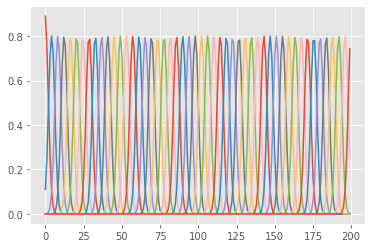

In [12]:
plt.plot(h.eval());

In [13]:
# create gains as optimal gains with given linear system Ax + Bu,
# quadratic value function S and quadratic cost on u R 
# we can also optimize gains K \in R^{u_dim x xi_dim}, but that way, we facilitate the optimization
R = rl.p.make_cov(u_dim, 10., param='iso', is_prec=True)
S = rl.p.make_cov(xi_dim, [0.02, 0.02, 0.5, 0.5], param='expm', batch_shape=(k_basis, ), is_prec=True)

#### Gains are computed that way: 

$K = (R + B^T S B)^{-1} B^T SA$

The stochastic policy is given as 

$u_t = \mathcal{N} (K_t (\hat{\xi_{t}}-\xi_t), \sigma_t I)$

In [14]:
pi_ks = tf.matmul(
    tf.linalg.inv(R[None] + B.matmul(
            B.matmul(S, adjoint=True), adjoint_arg=True, adjoint=True)),
    tf.linalg.LinearOperatorFullMatrix(B.matmul(S, adjoint=True)).matmul(A._matrix)
)   # gains

pi_target = tf.Variable(tf.random.normal((k_basis, xi_dim), 0., .2))  # target \hat{\xi}
pi_noise = tf.Variable(tf.ones((k_basis, 1)))  # stochasticity of the policy

# expand everything with basis functions
pi_target_t = tf.matmul(h, pi_target)    # expanded target \hat{\xi}
pi_noise_t = tf.matmul(h, tf.math.exp(pi_noise))    # expanded stochasticity of the policy
pi_ks_t = tf.einsum('ai,ijk->ajk', h, pi_ks)    # expanded gains
    
pi_params = [pi_target, pi_noise, R.variable, S.variable]   # variables to train

#### Specify time-dependent policy functions 

In [15]:
def pi(xi, t):
    """
    xi: [batch_size, xi_dim]
    t : int
    return u : [batch_size, u_dim]
    """
    
    xi_d = pi_target_t[t]
    sigma_u = pi_noise_t[t]
    k = pi_ks_t[t] 
        
    u = tf.linalg.LinearOperatorFullMatrix(k).matvec(xi_d - xi)
    
    return u + tf.random.normal((batch_size, u_dim), tf.zeros(u_dim), sigma_u)

#### Evaluate samples of whole trajectories 

In [16]:
if fast:
    ts0 = tf1.placeholder(tf.int32, ()) # trajectories can start anywhere
else:
    ts0 = 0 # trajectories always start at beginning

In [17]:
# create samples rollouts
samples_xis, samples_us = rl.control.rollout.make_rollout_samples(
    xi0, f, pi, u_dim=u_dim, T=horizon-1, t0=ts0,
    batch_shape=batch_size)

# concatenate xi and u
samples_xius = tf.concat([samples_xis, samples_us], axis=-1)

In [18]:
if fast: 
    # create full trajectories rollout for display purpose
    samples_xis_f, samples_us_f = rl.control.rollout.make_rollout_samples(
        xi0, f, pi, u_dim=u_dim, T=demos_horizon-1,
        batch_shape=batch_size)

    samples_xius_f = tf.concat([samples_xis_f, samples_us_f], axis=-1)
else:
    samples_xis_f, samples_us_f, samples_xius_f = samples_xis, samples_us, samples_xius

##  Discriminator
Create a discriminator that would distinguish between samples trajectories. 
Instead of using a MLP as proposed, we use a fast, closed form discriminator. It helps for the stability, data-efficiency and efficiency of the training.

We create two distributions $p_{samples}$ and $p_{data}$ and compute the probability of the generated samples trajectories $\tau$ to be in the distribution of data rather than samples as 
$$\frac{p_{data}(\tau)}{p_{data}(\tau) + p_{samples}(\tau)}$$

In [19]:
# a batched Gaussian distribution of trajectory (each timestep independent)
p_data = ds.MultivariateNormalFullCovarianceML(
    tf.Variable(tf.zeros((demos_horizon, xi_dim + u_dim))),
    tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(demos_horizon, ))),
)

if fast:
    # if fast, we extract parameters of full lengths of the demos
    p_data_partial = ds.MultivariateNormalFullCovariance(
        p_data.loc[ts0:ts0+horizon],
        p_data._cov_var[ts0:ts0+horizon]
    )
    
# the same for samples from our generator where the data is given
p_samples = ds.MultivariateNormalFullCovarianceML(
    tf.Variable(tf.zeros((horizon, xi_dim + u_dim))),
    tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(horizon, ))),
    data=samples_xius
)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [20]:
# plotting utilities
p_data_plot = rl.utils.plot.MVNPlot(p_data)
p_samples_plot = rl.utils.plot.MVNPlot(p_samples)

In [21]:
# temperature of discriminator
temp = tf.compat.v1.placeholder(tf.float32, ())

# normalized log probability to be in data or sample distribution
_p_data = p_data_partial if fast else p_data

# computes \frac{p_{data}(\tau)}{p_{data}(\tau) + p_{samples}(\tau)
p_log_prob = rl.utils.tf.log_normalize([
        temp * tf.reduce_mean(_p_data.log_prob(samples_xius), axis=1), 
        temp * tf.reduce_mean(p_samples.log_prob(samples_xius), axis=1)
    ], axis=0)   # stay in log for gradients 

# proability to be in data disrtibution 
p_data_prob = tf.exp(p_log_prob[0])

In [22]:
# the generator should maximize the probility that its samples are looking like the data
cost_gen = tf.reduce_mean(-p_log_prob[0]) 

### TO SHOW THAT IT CONVERGES TO THE MODE, what we don't want
#cost_gen = -tf.reduce_mean(temp * tf.reduce_mean(p_data.log_prob(samples_phi_xis), axis=1))

In [23]:
# SGD optimizer 
rate_gen = tf1.placeholder(tf.float32, ())
optimizer_gen = tf1.train.AdamOptimizer(rate_gen) # faster but less stable at the end
# optimizer_gen = tf1.train.AdagradOptimizer(rate_gen)  # slower
    
train_gen = optimizer_gen.minimize(
    cost_gen, var_list=pi_params
)

In [24]:
init = tf1.global_variables_initializer()

### (Re)loading data and learning samples model 
If you change letter, no need to reexecute everything above

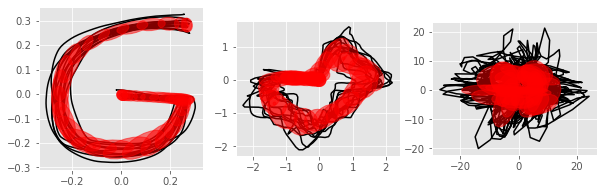

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
demos_xius = rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True)

# computing maximum likelihood of Gaussian distribution of trajectories with regularization
p_data.ml(demos_xius, reg_diag=[0.02, 0.02, 0.2, 0.2, 1., 1.])

for i, dim in enumerate([[0, 1], [2, 3], [4, 5]]):
    p_data_plot.plot_gmm(dim=dim, nb=5, ax=ax[i])
    for d in demos_xi:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], 'k')

## Training generator 

In [26]:
sess.run(init)

In [27]:
reg = [0.002, 0.002, 0.1, 0.1, 40., 40.]
feed_dict = {}
p_data.ml(demos_xius, reg_diag=reg)

In [28]:
n_it = 50000

feed_dict = {
        rate_gen : 0.01,  # start with this at the begining 
        rate_gen : 0.003,   # refine solutions
        p_samples.reg_diag:  reg,
        xi0 : get_batch(batch_size)[1]
    }

In [37]:
for i in range(n_it):  
    try:
        display.clear_output(wait=True)
        # generate samples from generator 
        _xi0, _t0= get_batch(batch_size, fast=fast) # get xius[0] and take only xdx
        feed_dict[xi0] = _xi0[:, :4]
        if fast:
            feed_dict[ts0] = _t0
        
        ################################
        # put 10 at the beginning for speed and 1 at the end for refinenement and stability
        feed_dict[temp] = 10.
        
        # the Gaussian distribution of samples is computed online by computing 
        # mean and covariances of samples and doing moment matching with previous solution
        # it allows to compute full covariances even with small number of samples
        # alpha specify the weights of the new computation 
        # if alpha is 1. we forget previous solution
        # it is a stochastic gradient descent equivalent of maximum likelihood for Gaussian
        if fast: # always use 1 because trajectories are not aligned between different batch
            feed_dict[p_samples.alpha] = 1. 
        else:
            feed_dict[p_samples.alpha] = 1. if i != 0 else 1.
        ################################
        
        
        # evaluating samples_xi = 0.03 [s]
        # running ml almost no time
        t0 = time.time()
        _ = sess.run([p_samples.online_ml_op], feed_dict)        
        
        # running ml almost no time
        _ , _c_g, _p_log_prob, _p_data = sess.run([train_gen, cost_gen, p_log_prob, p_data_prob], feed_dict)
        t1 = time.time()
        
        print('dt=%.2f[s]' % (t1- t0))
        print('Cost \t\t: %.3f' % _c_g)
        print('p_true\t\t: ', _p_data)   # should become close to 0.5 at convergence
        # print('log_p_true\t: ', _p_log_prob[0]) 
        # print(np.mean(pi_ks_t.eval(), axis=0))
        
    except KeyboardInterrupt:
        break

dt=0.08[s]
Cost 		: 15.944
p_true		:  [4.9048949e-06 1.9933123e-05 8.6934549e-01 5.3427396e-09 2.8581228e-04
 1.0365099e-13 1.7199192e-13 9.5342631e-12 9.9595696e-01 2.6067674e-11]


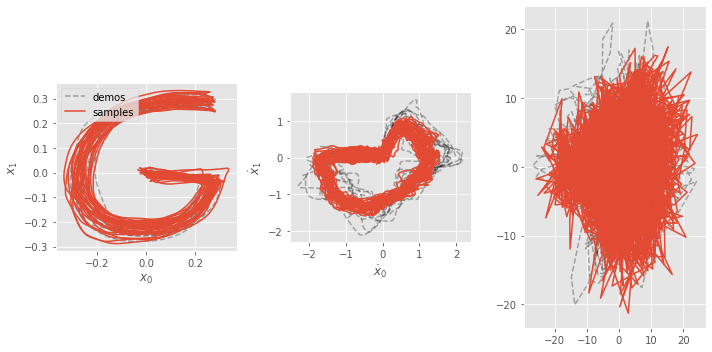

In [45]:
feed_dict[xi0] = get_batch(batch_size, fast=False)[0][:, :4] 

_s = []
for i in range(3): _samples_xis, = sess.run([samples_xius_f, ], feed_dict); _s += [_samples_xis]
_samples_xis = np.concatenate(_s, axis=0)
_xi_d, = sess.run([pi_target_t, ], feed_dict)   

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlabel(r'$x_0$')
ax[0].set_ylabel(r'$x_1$')
ax[1].set_xlabel(r'$\dot{x}_0$')
ax[1].set_ylabel(r'$\dot{x}_1$')

ax[0].plot([], [], alpha=.3, ls='--', color='k', label='demos')

for d in demos_xi:
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
    ax[2].set_prop_cycle(None)
    ax[0].plot(d[:, 0], d[:, 1], alpha=.3, ls='--', color='k')
    ax[1].plot(d[:, 2], d[:, 3], alpha=.3, ls='--', color='k')
    ax[2].plot(d[:, 4], d[:, 5], alpha=.3, ls='--', color='k')
    

ax[0].plot([], [], alpha=1., label='samples')

for d in _samples_xis:
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
    ax[2].set_prop_cycle(None)
    ax[0].plot(d[:, 0], d[:, 1], alpha=1.)
    ax[1].plot(d[:, 2], d[:, 3], alpha=1.)
    ax[2].plot(d[:, 4], d[:, 5], alpha=1.)
    

# ax[0].plot(_xi_d[:, 0], _xi_d[:, 1], alpha=1., lw=3)
# ax[1].plot(_xi_d[:, 2], _xi_d[:, 3], alpha=1., lw=3)
ax[0].legend()
plt.tight_layout()

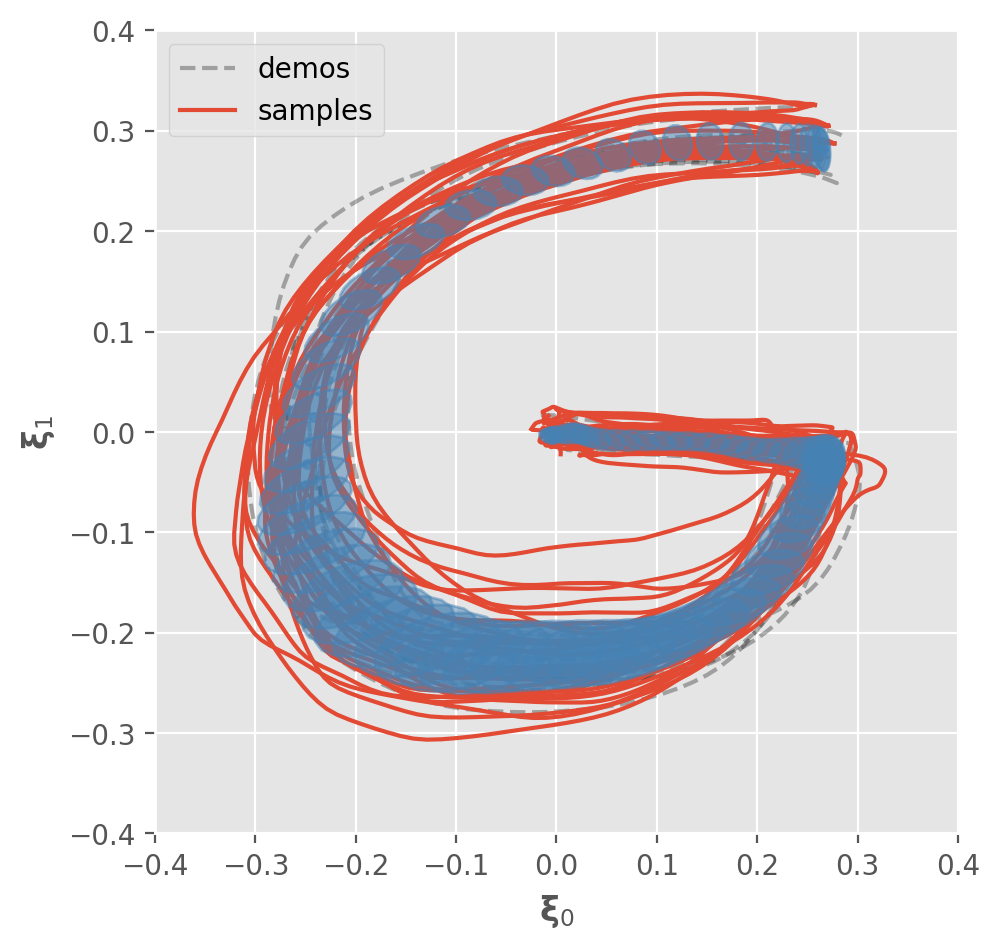

In [46]:
feed_dict[xi0] = get_batch(batch_size, fast=False)[0][:, :4] 

_s = []
for i in range(3): _samples_xis, = sess.run([samples_xius_f, ], feed_dict); _s += [_samples_xis]
_samples_xis = np.concatenate(_s, axis=0)
_xi_d, = sess.run([pi_target_t, ], feed_dict)   

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), dpi=200)
ax = [ax]
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\mathbf{\xi}_0$')
ax[0].set_ylabel(r'$\mathbf{\xi}_1$')

ax[0].plot([], [], alpha=.3, ls='--', color='k', label='demos')

lim = 0.4
ax[0].set_xlim([-lim, lim])
ax[0].set_ylim([-lim, lim])
for d in demos_xi:
    ax[0].set_prop_cycle(None)
    ax[0].plot(d[:, 0], d[:, 1], alpha=.3, ls='--', color='k')
p_samples_plot.plot(ax=ax[0], dim=[0, 1], nb=2, feed_dict=feed_dict, color='steelblue')
ax[0].plot([], [], alpha=1., label='samples')

for d in _samples_xis:
    ax[0].set_prop_cycle(None)
    ax[0].plot(d[:, 0], d[:, 1], alpha=1.)

# ax[0].plot(_xi_d[:, 0], _xi_d[:, 1], alpha=1., lw=3)
# ax[1].plot(_xi_d[:, 2], _xi_d[:, 3], alpha=1., lw=3)
ax[0].legend()
plt.tight_layout()

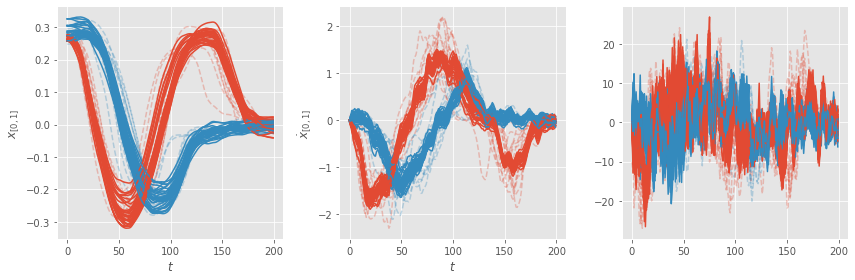

In [47]:
# del feed_dict[noise_std] 
# feed_dict[noise_std] = 1.
_s = []
for i in range(3):
    _samples_xis, = sess.run(
        [samples_xius_f, ], feed_dict)
    _s += [_samples_xis]
_samples_xis = np.concatenate(_s, axis=0)
    
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$x_{[0, 1]}$')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$\dot{x}_{[0, 1]}$')

for d in demos_xi:
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
    ax[2].set_prop_cycle(None)
    ax[0].plot(d[:, :2], alpha=.3, ls='--')
    ax[1].plot(d[:, 2:4], alpha=.3, ls='--')
    ax[2].plot(d[:, 4:6], alpha=.3, ls='--')
    
for d in _samples_xis:
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
    ax[2].set_prop_cycle(None)
    
    ax[0].plot(d[:, :2], alpha=1.)
    ax[1].plot(d[:, 2:4], alpha=1.)
    ax[2].plot(d[:, 4:6], alpha=1.)

# ax[0].plot(_xi_d[:, :2], alpha=1., lw=3)
# ax[1].plot(_xi_d[:, 2:], alpha=1., lw=3)


plt.tight_layout()

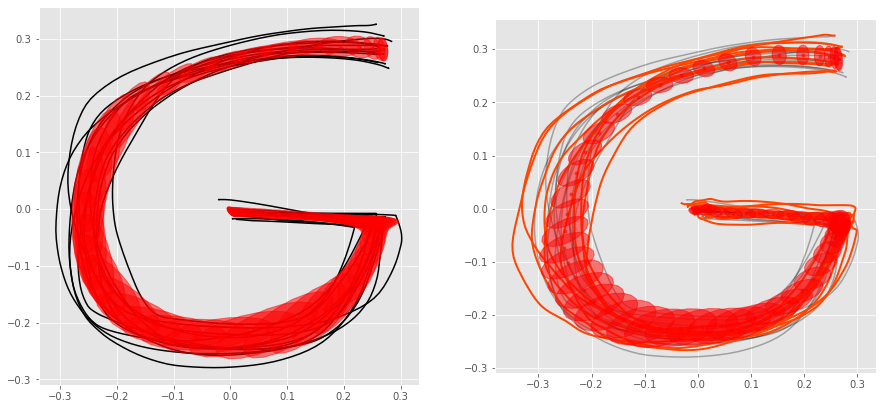

In [48]:
# feed_dict[noise_std] = 1.
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
dims = [0, 1]
# dims = [2, 3]

_samples_xis, = sess.run(
    [samples_xis], feed_dict)

for d in demos_xi:
    ax[0].plot(d[:, dims[0]], d[:, dims[1]], 'k')
    ax[1].plot(d[:, dims[0]], d[:, dims[1]], 'k', alpha=0.3)
    
for d in _samples_xis:
    ax[1].plot(d[:, dims[0]], d[:, dims[1]], 'orangered', lw=2)
    
n_sub = 3

p_data_plot.plot_gmm(dim=[0, 1], nb=3, ax=ax[0])
p_samples_plot.plot_gmm(dim=[0, 1], nb=3, ax=ax[1])